<a href="https://colab.research.google.com/github/engrwaseemakhtar/ISAC/blob/main/DeepSense_Workshop_2024_final_workshop2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Sensing-Aided Beam Prediction**

**Beam selection is a challenge:** Current and future communication systems are moving to higher frequency bands (mmWave in 5G and potentially sub-terahertz in 6G and beyond). The large available bandwidth at the high frequency bands enables these systems to satisfy the increasing data rate demands of the emerging applications, such as autonomous driving, edge computing, and mixed-reality. These systems, however, require deploying large antenna arrays at the transmitters and/or receivers and using narrow beams to guarantee sufficient receiver power. Finding the best beams (out of a pre-defined codebook) at the transmitter and receiver is associated with high beam training overhead (search time to find/align the best beams), which makes it difficult for these systems to support highly-mobile and latency-sensitive applications.


**Sensing aided beam prediction** is a promising solution: The dependence of mmWave/ THz communication systems on the LOS links between the transmitter/receiver means that the awareness about their locations and the surrounding environment (geometry of the buildings, moving scatterers, etc.) could potentially help the beam selection process. To that end, the sensing information of the environment and the UE could be utilized to guide the beam management and reduce beam training overhead significantly. For example, the sensory data collected by the RGB cameras, LiDAR, Radars, GPS receivers, etc., can enable the transmitter/receiver decide on where to point their beams (or at least narrow down the candidate beam steering directions).

**Towards real-world deployment:** Recent work on sensing-aided beam prediction has shown initial promising results in utilizing the sensory data such as RGB images, LiDAR, radar and GPS positions for the beam prediction problem. However, these solutions were mainly trained and tested on the same (mainly synthetic) datasets. To take these interesting ideas one step towards real-world deployments, we need to answer the following important question: Can sensing-aided beam prediction solutions perform well on real-world data?


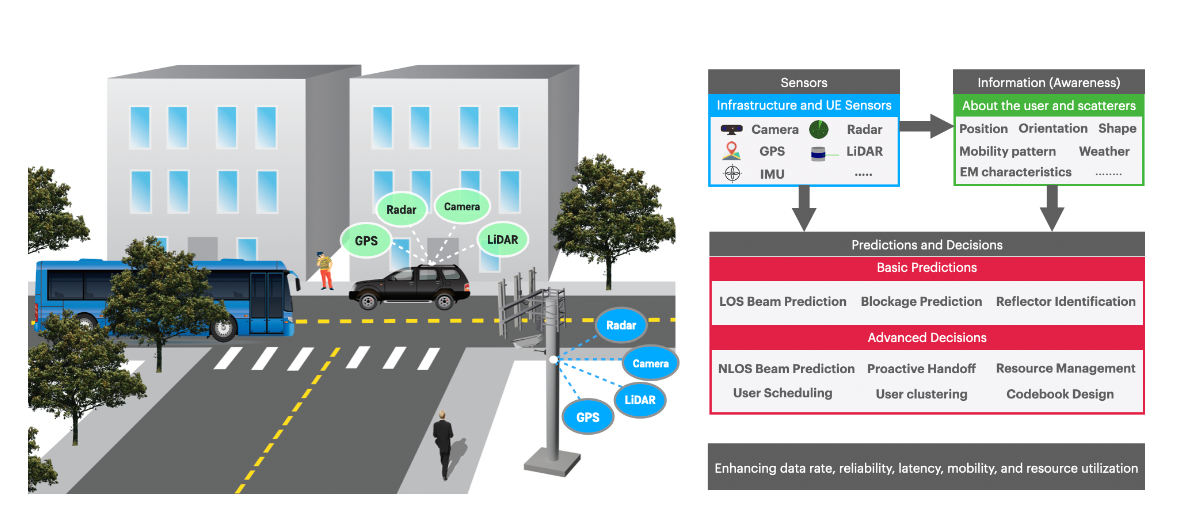

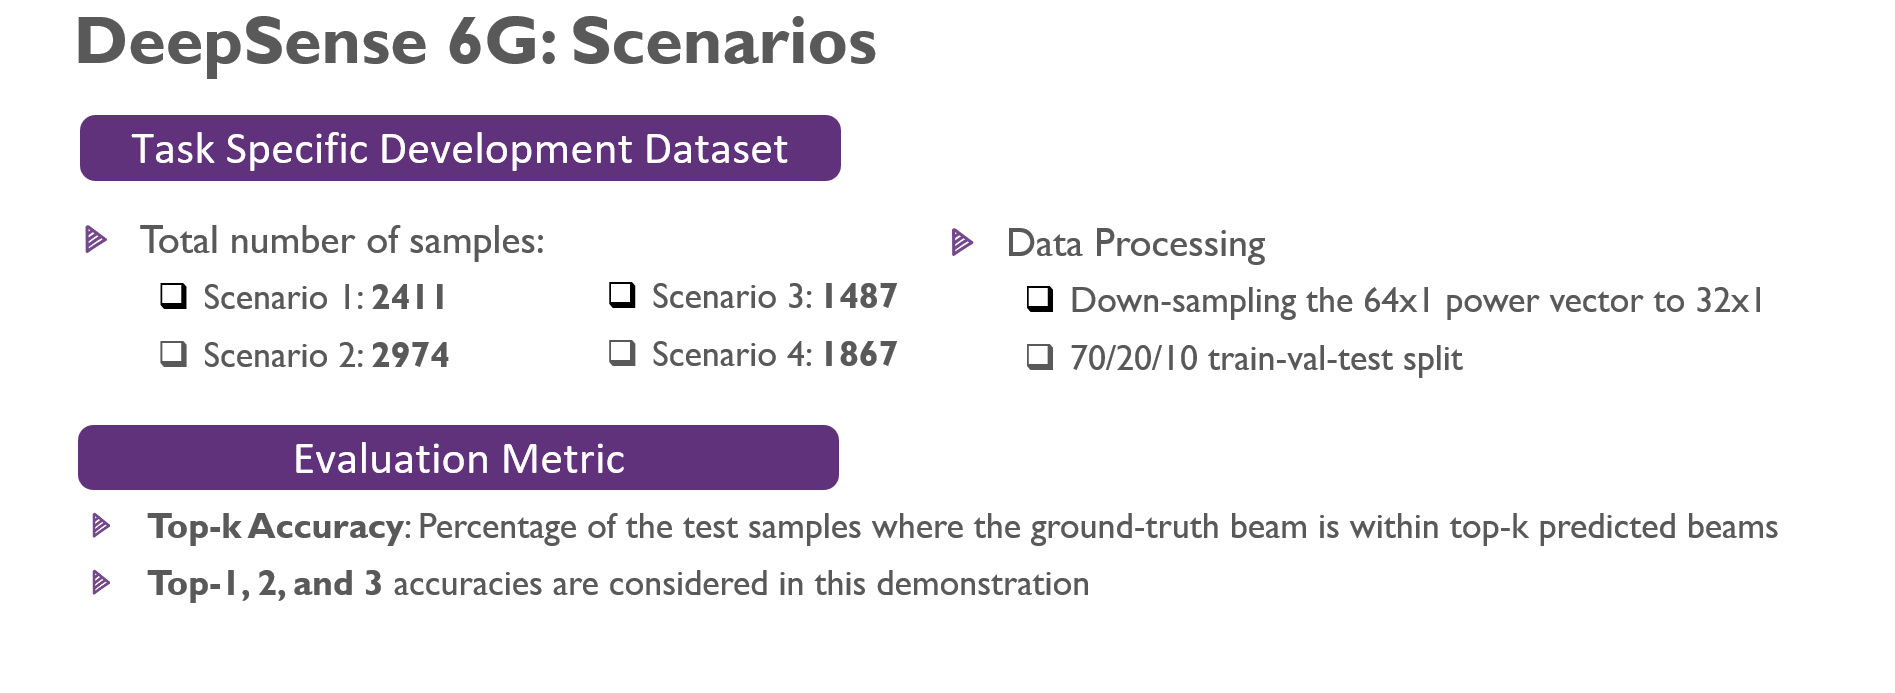

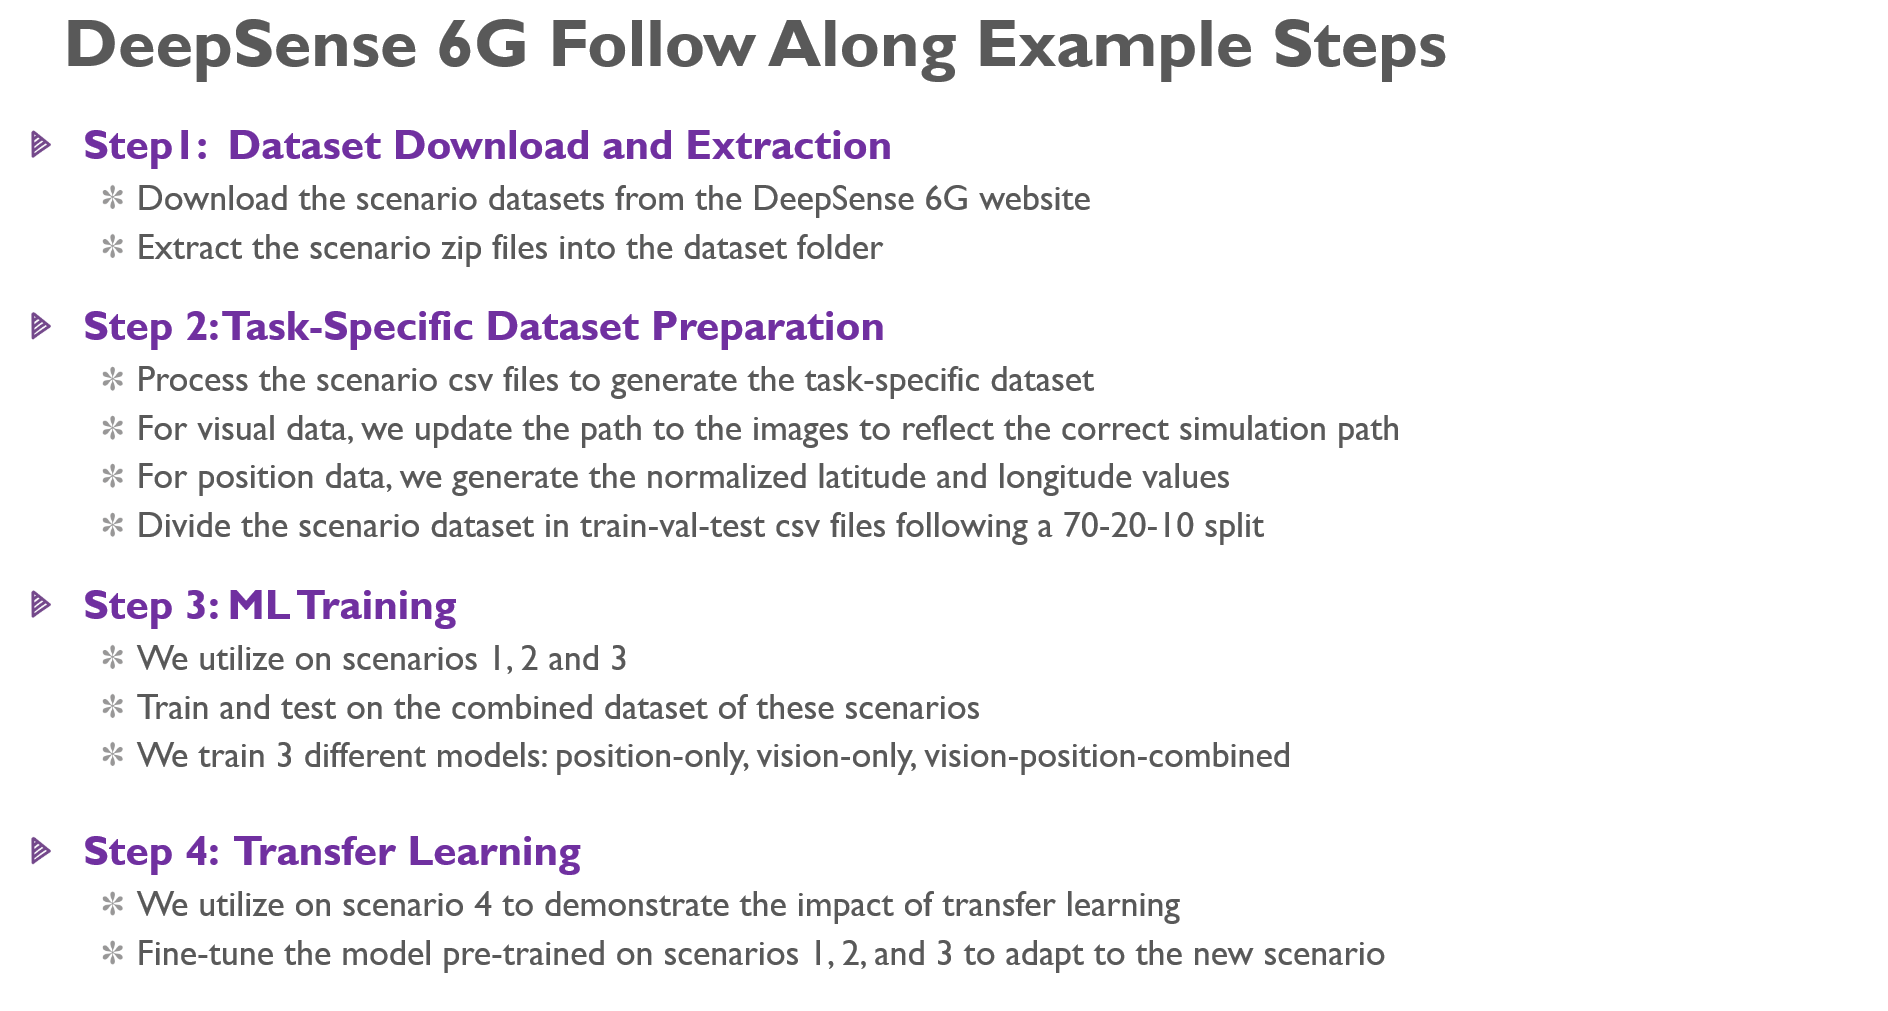


# **Step 1: Dataset Download and Extraction**
- URL Assignment:
  The URLs for the datasets are stored in variables `scenario1` and `scenario2`. This organization makes it easy to reference them later and keeps the download commands clean and understandable.

- Downloading Datasets:
  The `wget` command downloads files directly from the specified URLs. The `-O` option specifies the output filename, helping identify files related to specific scenarios. The use of Python's f-string format dynamically inserts the URL stored in the variable into the command, ensuring the download command is accurate and easy to modify.


- Setup for Extraction:
  The `zip_lst` array holds the names of the downloaded zip files. This list approach allows for easy expansion if more scenarios are added in the future.
  `extraction_path` specifies the directory where all files will be extracted, centralizing the extracted data and simplifying access for subsequent analysis or processing steps.

- Extraction Process:
  The script checks if the extraction directory exists and creates it if it doesn't, ensuring the extraction process won't fail due to a missing directory.
  It then iterates over each zip file, extracts its contents into the designated directory, and prints out a message indicating which file is currently being extracted. This provides clear feedback to the user about the progress of the extraction process.




In [ ]:
# Use wget to download the datasets from the provided URLs
!wget -q -O scenario1.zip "https://www.deepsense6g.net/?smd_process_download=1&download_id=5042"
!wget -q -O scenario2.zip "https://www.deepsense6g.net/?smd_process_download=1&download_id=5511"

!wget -q -O scenario3.zip "https://www.deepsense6g.net/?smd_process_download=1&download_id=5546"
!wget -q -O scenario4.zip "https://www.deepsense6g.net/?smd_process_download=1&download_id=5584"

In [ ]:
import os
import zipfile


# List of zip files to be extracted
zip_lst = ['scenario1.zip', 'scenario2.zip', 'scenario3.zip', 'scenario4.zip']
# Path where the extracted contents will be stored
extraction_path = './dataset'

# Ensure the extraction directory exists
os.makedirs(extraction_path, exist_ok=True)

# Loop through each zip file in the list and extract it
for zip_path in zip_lst:
    print(f"Extracting {zip_path}")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extraction_path)

print("Extraction complete!")

Extracting scenario1.zip
Extracting scenario2.zip
Extracting scenario3.zip
Extracting scenario4.zip
Extraction complete!


**Download Pre-Trained Models**

In [ ]:
!wget -q -O checkpoint.zip "https://www.dropbox.com/scl/fi/xk9yq0njk4ougcc57v569/checkpoint.zip?rlkey=0ffoqr5j5fpen41dcfp46q88s&dl=0"
!unzip checkpoint.zip

Archive:  checkpoint.zip
  inflating: checkpoint/beam_pred_model_position  
  inflating: checkpoint/beam_pred_model_vision_transfer_learning  
  inflating: checkpoint/beam_pred_model_vision_transfer_learning_partial_dataset  
  inflating: checkpoint/beam_pred_model_vision_v2  


# **Step 2: Task-Specific Data Preparation**

After downloading and extracting the datasets, the next stage is to prepare different subsets of the data tailored for specific machine learning tasks. This involves reading the extracted data, processing it according to the requirements of each task, and then organizing it into structured formats suitable for training machine learning models. The following cells will guide you through this process, detailing each step to ensure clarity and comprehension.


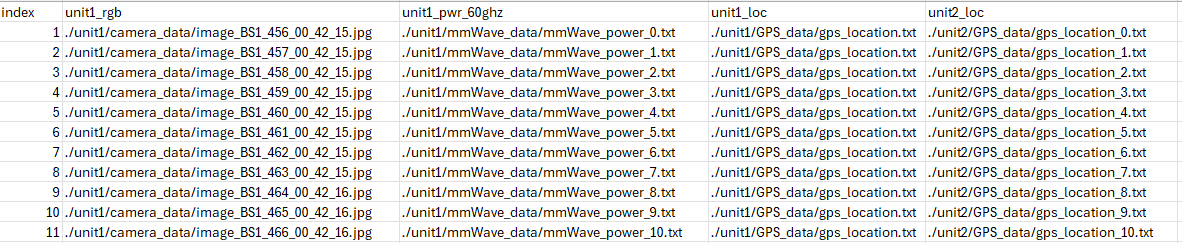

**What does this include?**
Reading the scenario csv file --> Updating the paths to the sensing modality --> Normalizing any data (if needed) --> computing the optimal beams (subsample if needed

**Setups and Imports:**

In [ ]:
import os
import random
import datetime

import numpy as np
import pandas as pd

import torch
from sklearn.utils import shuffle
import matplotlib.pyplot as plt


#from numpy.random import RandomState

In [ ]:
def set_seed(seed=42):
    """Sets the seed for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if using multi-GPU.
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [ ]:
seed_num = 42
set_seed(seed_num)

In [ ]:
# Get the current working directory
current_path = os.getcwd()

# Define the scenario and set up directory paths
data_root = os.path.join(current_path, 'dataset')
processed_data = os.path.join(current_path, 'task_specific_data')


if not os.path.exists(processed_data):
    os.makedirs(processed_data)


In [ ]:
# Function to subsample power data and update beam indices
def subsample_and_update_beams(pwr_data_lst, scenario_path):
    updated_beam, original_beam = [], []

    for entry in pwr_data_lst:
        data_to_read = f'{scenario_path}/{entry[1:]}'
        pwr_data = np.loadtxt(data_to_read)
        original_beam.append(np.argmax(pwr_data) + 1)
        updated_pwr = pwr_data[::2]  # subsample every other power entry
        updated_beam.append(np.argmax(updated_pwr) + 1)

    return updated_beam, original_beam

In [ ]:
def create_subsampled_dataset(scenario_num):
    scenario_root = f'{data_root}/Scenario{scenario_num}'
    data_csv = f'{scenario_root}/scenario{scenario_num}.csv'

    # Check if the path exists or not
    isExist = os.path.exists(data_csv)
    if isExist:
        print("The directory exists.")
    else:
        print("Error: The directory does not exist, please check the path.")

    # Read the initial dataset
    df = pd.read_csv(data_csv)
    image_data_lst = df['unit1_rgb'].values
    pwr_data_lst = df['unit1_pwr_60ghz'].values


    updated_beam, original_beam = subsample_and_update_beams(pwr_data_lst, scenario_root)
    return updated_beam, original_beam



In [ ]:
def create_img_beam_dataset(scenario_num, seed_num, processed_data_path):

    folder_to_save = f'{processed_data_path}/Scenario{scenario_num}/image_beam'
    if not os.path.exists(folder_to_save):
        os.makedirs(folder_to_save)

    scenario_root = f'{data_root}/Scenario{scenario_num}'
    data_csv = f'{scenario_root}/scenario{scenario_num}.csv'
    print(data_csv)

    updated_beam, original_beam = create_subsampled_dataset(scenario_num)

    # Read the initial dataset
    df = pd.read_csv(data_csv)
    image_data_lst = df['unit1_rgb'].values
    print(len(image_data_lst))

    #############################################
    ###### created updated image path ###########
    #############################################
    updated_img_path = []
    for entry in image_data_lst:
        img_path = entry.split('./')[1]
        updated_path = f'{scenario_root}/{img_path}'
        #print("updated path", updated_path)
        updated_img_path.append(updated_path)


    #############################################
    # saving the image-beam development dataset for training and validation
    #############################################

    indx = np.arange(1, len(updated_beam)+1,1)
    df_new = pd.DataFrame()
    df_new['index'] = indx
    df_new['unit1_rgb'] = updated_img_path
    df_new['unit1_beam_32'] = updated_beam
    df_new['unit1_beam_64'] = original_beam
    df_new.to_csv(fr'{folder_to_save}/scenario{scenario_num}_image_beam.csv', index=False)

    #############################################
    #generate the train and test dataset
    #############################################
    #rng = RandomState(1)
    train, val, test = np.split(df_new.sample(frac=1, random_state=seed_num ), [int(.6*len(df_new)), int(.9*len(df_new))])
    #train, val, test = np.split(df_new.sample(frac=1), [int(.6*len(df_new)), int(.9*len(df_new))])
    train.to_csv(f'{folder_to_save}/scenario{scenario_num}_image_beam_train.csv', index=False)
    val.to_csv(f'{folder_to_save}/scenario{scenario_num}_image_beam_val.csv', index=False)
    test.to_csv(f'{folder_to_save}/scenario{scenario_num}_image_beam_test.csv', index=False)


In [ ]:
create_img_beam_dataset(1, seed_num, processed_data)
create_img_beam_dataset(2, seed_num, processed_data)
create_img_beam_dataset(3, seed_num, processed_data)
create_img_beam_dataset(4, seed_num, processed_data)

/content/dataset/Scenario1/scenario1.csv
The directory exists.
2411
/content/dataset/Scenario2/scenario2.csv
The directory exists.
2974
/content/dataset/Scenario3/scenario3.csv
The directory exists.
1487
/content/dataset/Scenario4/scenario4.csv
The directory exists.
1867


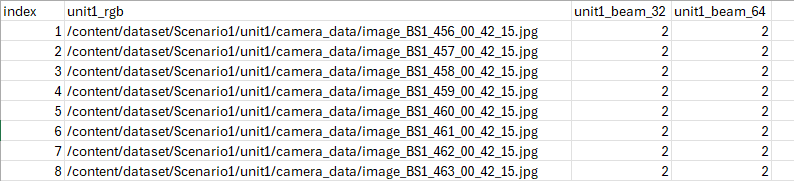

In [ ]:
def create_pos_beam_dataset(scenario_num, seed_num, processed_data_path):

    folder_to_save = f'{processed_data_path}/Scenario{scenario_num}/pos_beam'
    if not os.path.exists(folder_to_save):
        os.makedirs(folder_to_save)

    scenario_root = f'{data_root}/Scenario{scenario_num}'
    data_csv = f'{scenario_root}/scenario{scenario_num}.csv'

    updated_beam, original_beam = create_subsampled_dataset(scenario_num)

    # Read the initial dataset
    df = pd.read_csv(data_csv)
    pwr_data_lst = df['unit1_pwr_60ghz'].values

    ###############################################
    ####### read position values from dataset #####
    ###############################################

    lat = []
    lon = []
    pos_data_path = df['unit2_loc'].values
    for entry in pos_data_path:
        data_to_read = f'{scenario_root}/{entry[1:]}'
        pos_val = np.loadtxt(data_to_read)
        #lat_val, lon_val = pos_val[0], pos_val[1]
        lat.append(pos_val[0])
        lon.append(pos_val[1])

    def norm_data(data_lst):
        norm_data = []
        for entry in data_lst:
            norm_data.append((entry - min(data_lst))/(max(data_lst) - min(data_lst)))
        return norm_data

    ###############################################
    ##### normalize latitude and longitude data ###
    ###############################################
    lat_norm = norm_data(lat)
    lon_norm = norm_data(lon)

    ###############################################
    ##### generate final pos data #################
    ###############################################
    pos_data = []
    for j in range(len(lat_norm)):
        pos_data.append([lat_norm[j], lon_norm[j]])


    #############################################
    # saving the pos-beam development dataset for training and validation
    #############################################

    indx = np.arange(1, len(updated_beam)+1,1)
    df_new = pd.DataFrame()
    df_new['index'] = indx
    df_new['unit2_pos'] = pos_data
    df_new['unit1_beam_32'] = updated_beam
    df_new['unit1_beam_64'] = original_beam
    df_new.to_csv(fr'{folder_to_save}/scenario{scenario_num}_pos_beam.csv', index=False)

    #############################################
    #generate the train and test dataset
    #############################################
    #rng = RandomState(1)
    train, val, test = np.split(df_new.sample(frac=1, random_state=seed_num ), [int(.6*len(df_new)), int(.9*len(df_new))])
    #train, val, test = np.split(df_new.sample(frac=1), [int(.6*len(df_new)), int(.9*len(df_new))])
    train.to_csv(f'{folder_to_save}/scenario{scenario_num}_pos_beam_train.csv', index=False)
    val.to_csv(f'{folder_to_save}/scenario{scenario_num}_pos_beam_val.csv', index=False)
    test.to_csv(f'{folder_to_save}/scenario{scenario_num}_pos_beam_test.csv', index=False)



In [ ]:
create_pos_beam_dataset(1, seed_num, processed_data)
create_pos_beam_dataset(2, seed_num, processed_data)
create_pos_beam_dataset(3, seed_num, processed_data)
create_pos_beam_dataset(4, seed_num, processed_data)

The directory exists.
The directory exists.
The directory exists.
The directory exists.


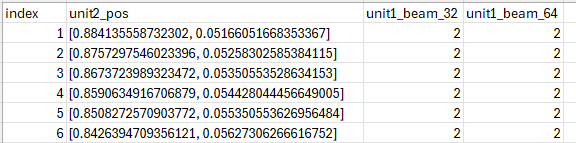

# **Step 3: ML Training**

**Directory Setup for Machine Learning Experiments**
This script is designed to set up and organize directories for saving various outputs and checkpoints related to machine learning experiments. It ensures that all necessary directories exist and are ready for use to store training artifacts, analysis files, and model checkpoints. Here’s a step-by-step explanation of the script’s operations:

**Base Directory Initialization:**
The variable ML_code is set to /content/ML_code, specifying the root directory intended for all machine learning code and related files.
If this directory does not exist, it is created using os.makedirs. This ensures that there is a dedicated space in the filesystem to organize and store machine learning project files.

**Timestamp Creation:** The script generates timestamps to uniquely identify each experiment or session. This is done using Python’s datetime module.


**Working Directory Setup:**
A path pwd is constructed combining the base directory, a subfolder named saved_folder, and the current date and time. This path is where all files related to the current session or experiment will be stored.
The script checks if this directory exists. If not, it creates the directory using os.makedirs.

**Subdirectories for Analysis Files and Checkpoints:**
Inside the session-specific directory (pwd), additional subdirectories are created:
* saved_analysis_files: Intended to store output files, logs, figures, or any
other analysis results.
* checkpoint: Designated for saving model checkpoints during training, which allows for model recovery and resuming training if necessary.

The existence of each subdirectory is checked. If a directory does not exist, it is created.

In [ ]:
ML_code = os.path.join(current_path, 'ML_code')

if not os.path.exists(ML_code):
    os.makedirs(ML_code)

# year month day
dayTime = datetime.datetime.now().strftime('%m-%d-%Y')
# Minutes and seconds
hourTime = datetime.datetime.now().strftime('%H_%M')
print(dayTime + '\n' + hourTime)

pwd = '/content/ML_code' + '/' + 'saved_folder' + '/' + dayTime + '_' + hourTime
print(pwd)
# Determine whether the folder already exists
isExists = os.path.exists(pwd)
if not isExists:
    os.makedirs(pwd)



#create folder to save analysis files and checkpoint

save_directory = pwd + '/' + 'saved_analysis_files'
checkpoint_directory = pwd + '/' + 'checkpoint'

isExists = os.path.exists(save_directory)
if not isExists:
    os.makedirs(save_directory)

isExists = os.path.exists(checkpoint_directory)
if not isExists:
    os.makedirs(checkpoint_directory)

05-22-2024
12_12
/content/ML_code/saved_folder/05-22-2024_12_12


**AI-Ready Dataset**

This function is designed to handle the preparation of training, validation, and testing datasets for different modalities within a machine learning workflow. It efficiently manages datasets across various scenarios, ensuring that they are properly combined and shuffled according to specified modalities. Here's how it functions:

**Initialization:** The function starts by setting a base path where scenario-specific data is stored. This path is assumed to contain subfolders for different scenarios, each containing datasets split by training, validation, and testing.

**Modality Handling:** It defines a mapping of modalities to their respective folder names (position, vision, vision-position). This mapping helps the function navigate to the correct dataset folder based on the specified modality.

**Scenario Processing:**


*   For each scenario number provided, the function constructs the path to the data folder corresponding to the current modality.
*   It verifies the existence of this folder, skipping the scenario if the folder is not found, thus avoiding errors in attempting to access nonexistent paths.

**Data Aggregation:**


*   For each type of dataset (train, validation, test), the function attempts to read CSV files from the respective folders.
*   These CSV files are then accumulated into separate lists for training, validation, and testing dataframes, depending on their split type.

**Shuffling:**
After combining all dataframes for each split, the function shuffles them to ensure that the data order does not affect the learning process. This shuffling uses a specified random seed to allow reproducibility of the dataset order across different runs.

**Output:**
Finally, the function returns three dataframes: one for training, one for validation, and one for testing. Each dataframe is a combination of all corresponding split data from all included scenarios, shuffled and ready for use in training or evaluating a model.

In [ ]:
def combine_shuffle_datasets(train_scenario_nums, test_scenario_nums, modality, percentages=None, seed=42):
    #base_path = '/content/task_specific_data'
    base_path = os.path.join(current_path, 'task_specific_data')

    # DataFrames for each split
    train_dfs = []
    val_dfs = []
    test_dfs = []

    # Supported modalities mapping to their respective folders
    modality_mapping = {
        'position': 'pos_beam',
        'vision': 'image_beam',
        'vision-position': 'img_pos_beam'
    }

    # Check if the provided modality is supported
    if modality not in modality_mapping:
        print(f"Error: Modality '{modality}' is not supported.")
        return None

    # Process each training scenario number
    for i, num in enumerate(train_scenario_nums):
        scenario_folder = f'Scenario{num}'
        full_path = os.path.join(base_path, scenario_folder, modality_mapping[modality])

        # Check if the scenario modality path exists
        if not os.path.exists(full_path):
            print(f"Warning: The path for scenario {num} with modality '{modality}' does not exist. Skipping.")
            continue

        # Handle training data
        train_file_path = os.path.join(full_path, f'scenario{num}_{modality_mapping[modality]}_train.csv')
        if os.path.isfile(train_file_path):
            train_df = pd.read_csv(train_file_path)
            if percentages and percentages[i] < 100:
                train_df = train_df.sample(frac=percentages[i]/100, random_state=seed)
            train_dfs.append(train_df)
        else:
            print(f"Warning: The file {train_file_path} does not exist. Skipping this scenario.")

        # Handle validation data
        val_file_path = os.path.join(full_path, f'scenario{num}_{modality_mapping[modality]}_val.csv')
        if os.path.isfile(val_file_path):
            val_df = pd.read_csv(val_file_path)
            val_dfs.append(val_df)
        else:
            print(f"Warning: The file {val_file_path} does not exist. Skipping this scenario.")

    # Process each testing scenario number
    for num in test_scenario_nums:
        scenario_folder = f'Scenario{num}'
        full_path = os.path.join(base_path, scenario_folder, modality_mapping[modality])

        # Check if the scenario modality path exists
        if not os.path.exists(full_path):
            print(f"Warning: The path for scenario {num} with modality '{modality}' does not exist. Skipping.")
            continue

        # Handle test data
        test_file_path = os.path.join(full_path, f'scenario{num}_{modality_mapping[modality]}_test.csv')
        if os.path.isfile(test_file_path):
            test_df = pd.read_csv(test_file_path)
            test_dfs.append(test_df)
        else:
            print(f"Warning: The file {test_file_path} does not exist. Skipping this scenario.")

    # Concatenate and shuffle the datasets
    train_combined_df = shuffle(pd.concat(train_dfs, ignore_index=True), random_state=seed).reset_index(drop=True)
    val_combined_df = shuffle(pd.concat(val_dfs, ignore_index=True), random_state=seed).reset_index(drop=True)
    test_combined_df = shuffle(pd.concat(test_dfs, ignore_index=True), random_state=seed).reset_index(drop=True)

    return train_combined_df, val_combined_df, test_combined_df

In [ ]:
import torch.cuda as cuda
import torch.optim as optimizer
import torch.nn as nn
import torch.nn.functional as F

import torchvision.models as models
from torchvision import transforms as transforms
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader

from PIL import Image
import torch
import ast

from tqdm import tqdm

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, modality='vision', transform=None):
        """
        Args:
            dataframe (pandas.DataFrame): The dataframe containing the dataset.
            modality (str): Modality to use ('vision', 'position', or 'vision-position').
            transform (callable, optional): Optional transform to be applied on an image.
        """
        self.data = dataframe
        self.modality = modality
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if self.modality in ['vision', 'vision-position']:
            img_path = self.data.loc[idx, 'unit1_rgb']
            image = Image.open(img_path).convert('RGB')
            if self.transform:
                image = self.transform(image)

        if self.modality in ['position', 'vision-position']:
            position = ast.literal_eval(self.data.loc[idx, 'unit2_pos'])
            position = torch.tensor(position, dtype=torch.float32)

        label = self.data.loc[idx, 'unit1_beam_32']

        if self.modality == 'vision':
            return image, label
        elif self.modality == 'position':
            return position, label
        elif self.modality == 'vision-position':
            return image, position, label
        else:
            raise ValueError("Invalid modality specified. Choose from 'vision', 'position', or 'vision-position'.")


**ML Models**

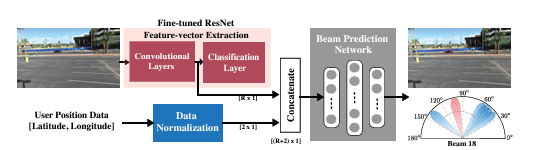

In [ ]:
# Define the custom model for image input
class CustomImageModel(nn.Module):
    def __init__(self, num_classes):
        super(CustomImageModel, self).__init__()
        # Load a pre-trained ResNet18 model to utilize transfer learning
        self.resnet = models.resnet18(pretrained=True)
        # Retrieve the number of input features to the fully connected layer
        num_ftrs = self.resnet.fc.in_features
        # Modify the fully connected layer to match the number of target classes
        self.resnet.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, image):
        # Perform a forward pass through the modified ResNet18 model with the image as input
        return self.resnet(image)

# Define the custom model for position input
class CustomPositionModel(nn.Module):
    def __init__(self, num_classes, layer_sizes=[64, 128, 64], dropout_prob=0.3):
        super(CustomPositionModel, self).__init__()
        # Initialize module lists to store layers, batch normalization, and dropout layers
        self.layers = nn.ModuleList()
        self.batch_norms = nn.ModuleList()
        self.dropouts = nn.ModuleList()

        # Set the initial input size (e.g., for a 2D position vector)
        input_size = 2
        for size in layer_sizes:
            # Append linear layers, batch normalization, and dropout layers
            self.layers.append(nn.Linear(input_size, size))
            self.batch_norms.append(nn.BatchNorm1d(size))
            self.dropouts.append(nn.Dropout(dropout_prob))
            input_size = size

        # Define the output layer to map the final layer size to the number of classes
        self.output = nn.Linear(layer_sizes[-1], num_classes)

    def forward(self, x):
        # Sequentially apply layers with LeakyReLU activation, followed by batch normalization and dropout
        for layer, norm, dropout in zip(self.layers, self.batch_norms, self.dropouts):
            x = F.leaky_relu(layer(x))
            x = norm(x)
            x = dropout(x)

        # Return the output of the final layer
        return self.output(x)

# Define the custom model for image and position combined input
class CustomImagePositionModel(nn.Module):
    def __init__(self, num_classes):
        super(CustomImagePositionModel, self).__init__()
        # Load a pre-trained ResNet18 model without the final fully connected layer
        self.resnet = models.resnet18(pretrained=True)
        self.resnet = nn.Sequential(*list(self.resnet.children())[:-1])
        # Define the fully connected layer to handle combined features from image and position
        self.fc = nn.Linear(512 + 2, num_classes)  # 512 for image features from ResNet, 2 for position

    def forward(self, image, position):
        # Extract image features using ResNet
        image_features = self.resnet(image)
        # Flatten the features to prepare for concatenation
        image_features = image_features.view(image_features.size(0), -1)
        # Concatenate image and position features
        concatenated_features = torch.cat((image_features, position), dim=1)
        # Output the result of the fully connected layer
        output = self.fc(concatenated_features)
        return output

In [ ]:
# Factory function to get the model
def get_model(modality, num_classes=None, num_features=None, num_output=None):
    if modality == 'vision':
        if num_classes is None:
            raise ValueError("num_classes must be specified for image modality")
        return CustomImageModel(num_classes=num_classes)
    elif modality == 'position':
        if num_classes is None:
            raise ValueError("num_classes must be specified for position modality")
        return CustomPositionModel(num_classes=num_classes)
    elif modality == 'vision-position':
        if num_classes is None:
            raise ValueError("num_classes must be specified for image-position modality")
        return CustomImagePositionModel(num_classes=num_classes)
    else:
        raise ValueError(f"Unknown modality: {modality}")


In [ ]:

# Enhanced transformation pipeline with data augmentation for training
train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),            # Resize to a slightly larger square
    transforms.RandomCrop((224, 224)),        # Randomly crop to 224x224
    transforms.RandomHorizontalFlip(),        # Randomly flip the images horizontally
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),  # Randomly alter the color properties
    transforms.ToTensor(),                    # Convert images to tensors
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))  # Normalize the images
])

# Validation and test transformations can be less aggressive since we're not training on this data
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the images to 224x224
    transforms.ToTensor(),          # Convert images to tensors
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))  # Normalize the images
])


In [ ]:
def train(model, train_loader, criterion, optimizer, device, modality):
    model.train()
    running_loss = 0
    for data in tqdm(train_loader, desc="Training"):
        optimizer.zero_grad()
        if modality == 'vision-position':
            img, pos, label = data
            img, pos, label = img.to(device), pos.to(device), label.to(device)
            outputs = model(img, pos)
        else:
            inputs, label = data
            inputs, label = inputs.to(device), label.to(device)
            outputs = model(inputs)

        loss = criterion(outputs, label)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    average_loss = running_loss / len(train_loader)
    print(f'Average Training Loss: {average_loss}')
    return average_loss


In [ ]:
def validate(model, val_loader, device, modality):
    model.eval()
    top1_acc, top2_acc, top3_acc = 0, 0, 0
    total_count = 0
    results = {'top1_pred': [], 'top2_pred': [], 'top3_pred': [], 'labels': []}
    with torch.no_grad():
        for data in tqdm(val_loader, desc="Validation"):
            if modality == 'vision-position':
                imgs, pos, labels = data
                imgs, pos, labels = imgs.to(device), pos.to(device), labels.to(device)
                outputs = model(imgs, pos)
            else:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)

            _, top1_pred = torch.max(outputs, 1)
            sorted_out = torch.argsort(outputs, dim=1, descending=True)
            results['labels'].extend(labels.cpu().numpy().tolist())
            results['top1_pred'].extend(top1_pred.cpu().numpy().tolist())
            results['top2_pred'].extend(sorted_out[:, :2].cpu().numpy().tolist())
            results['top3_pred'].extend(sorted_out[:, :3].cpu().numpy().tolist())
            top1_acc += torch.sum(top1_pred == labels).item()
            top2_acc += torch.sum(sorted_out[:, :2] == labels.unsqueeze(1)).sum().item()
            top3_acc += torch.sum(sorted_out[:, :3] == labels.unsqueeze(1)).sum().item()
            total_count += labels.size(0)
    print(f'Validation Accuracy - Top1: {top1_acc / total_count}, Top2: {top2_acc / total_count}, Top3: {top3_acc / total_count}')
    return top1_acc / total_count, top2_acc / total_count, top3_acc / total_count, results



In [ ]:
def log_and_save_results(results, save_directory, epoch):
    file_to_save = f'{save_directory}/top_pred_beam_{epoch+1}.csv'
    df = pd.DataFrame(results)
    df.to_csv(file_to_save, index=False)
    print(f"Results saved to {file_to_save}")

In [ ]:
def main_training_loop(train_df, val_df, test_df, device, modality, batch_size=64):

    model = get_model(modality, num_classes=65)
    model = model.to(device)

    # Example usage:
    #train_df, val_df, test_df = combine_shuffle_datasets([1, 2], modality, seed=seed_num)
    print(train_df.head())  # Display the first few rows of the train, val, and test data

    print(pwd)

    train_df.to_csv(f'{pwd}/train.csv', index=False)
    val_df.to_csv(f'{pwd}/val.csv', index=False)
    test_df.to_csv(f'{pwd}/test.csv', index=False)

    # Set the batch sizes and number of workers
    batch_size = batch_size
    val_batch_size = 1
    num_workers = 2  # Adjust based on the capabilities of your machine

    lr = 1e-4
    decay = 1e-4


    # Create dataset instances for each DataFrame
    train_dataset = CustomDataset(dataframe=train_df, modality=modality, transform=train_transforms)
    val_dataset = CustomDataset(dataframe=val_df, modality=modality, transform=test_transforms)
    test_dataset = CustomDataset(dataframe=test_df, modality=modality, transform=test_transforms)

    # Set up the DataLoader for each dataset
    train_loader = DataLoader(train_dataset,
                              batch_size=batch_size,
                              shuffle=True,  # Shuffle for training to randomize input
                              num_workers=num_workers)

    val_loader = DataLoader(val_dataset,
                            batch_size=val_batch_size,
                            shuffle=False,  # No need to shuffle validation and test data
                            num_workers=num_workers)

    test_loader = DataLoader(test_dataset,
                            batch_size=val_batch_size,
                            shuffle=False,
                            num_workers=num_workers)


    criterion = nn.CrossEntropyLoss()
    opt = optimizer.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
    if modality == 'position':
        scheduler = optimizer.lr_scheduler.MultiStepLR(opt, milestones=[20, 30], gamma=0.1)
        num_epochs = 40
    else:
        scheduler = optimizer.lr_scheduler.MultiStepLR(opt, milestones=[4, 8], gamma=0.1)
        num_epochs = 15

    best_accuracy = 0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}')
        train(model, train_loader, criterion, opt, device, modality)
        accuracy, _, _, results = validate(model, val_loader, device, modality)
        log_and_save_results(results, save_directory, epoch)

        print("current acc", accuracy)
        print("best acc", best_accuracy)
        if accuracy > best_accuracy:
            print("Saving the best model")
            net_name = checkpoint_directory  + '/' +  f'beam_pred_model_{modality}'
            torch.save(model.state_dict(), net_name)
            best_accuracy =  accuracy
        print("updated best acc", best_accuracy)

        scheduler.step()



    # Load the best checkpoint
    # Assuming the best model's name is preserved in `net_name`, load the best model
    best_model_path = net_name  # This should be the path where the best model is saved
    model.load_state_dict(torch.load(best_model_path))
    model.to(device)  # Ensure model is on the correct device

    print("Model accuracy on the test set")

    # Optionally, evaluate the model to confirm it's loaded correctly and check performance
    model.eval()
    test_accuracy, _, _, test_results = validate(model, test_loader, device, modality)
    #print(f'Loaded Model Accuracy: {accuracy}')
    return model, test_results

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# **Position Aided Beam Prediction**

In [ ]:
modality = 'position'

train_scenario_nums = [1, 2, 3]  # Scenarios 1, 2, and 3 will be used for training
test_scenario_nums = [1, 2, 3]      # Scenarios 4 and 5 will be used for testing

# Define the percentage of data to be used from each training scenario
percentages = [40, 40, 40]  # Use 40% of Scenario 1, 40% of Scenario 2, and 40% of Scenario 3

# Run the function
train_df, val_df, test_df = combine_shuffle_datasets(train_scenario_nums, test_scenario_nums, modality, percentages)

model_pos, results_pos = main_training_loop(train_df, val_df, test_df, device, modality)

# Assuming `results` is returned from `validate`
labels = results_pos['labels']
top1_preds = results_pos['top1_pred']

# Calculate the confusion matrix
cm = confusion_matrix(labels, top1_preds)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 7))
sns.heatmap(cm_normalized, cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


Validation: 100%|██████████| 689/689 [00:05<00:00, 134.46it/s]


Validation Accuracy - Top1: 0.3599419448476052, Top2: 0.5239477503628447, Top3: 0.6226415094339622


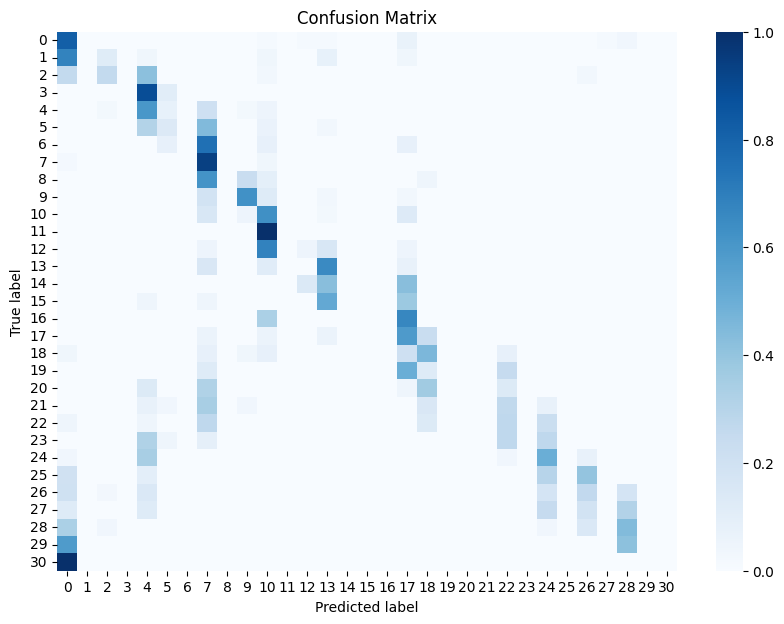

In [ ]:
modality = 'position'
pos_ckpt = '/content/checkpoint/beam_pred_model_position'
model_pos = get_model(modality, num_classes=65)
model_pos = model_pos.to(device)

best_model_path = pos_ckpt  # This should be the path where the best model is saved
model_pos.load_state_dict(torch.load(best_model_path))
model_pos.to(device)  # Ensure model is on the correct device

model_pos.eval()

train_scenario_nums = [1, 2, 3]  # Scenarios 1, 2, and 3 will be used for training
test_scenario_nums = [1, 2, 3]      # Scenarios 4 and 5 will be used for testing

# Define the percentage of data to be used from each training scenario
percentages = [40, 40, 40]  # Use 40% of Scenario 1, 40% of Scenario 2, and 40% of Scenario 3

# Run the function
train_df_pos, val_df_pos, test_df_pos = combine_shuffle_datasets(train_scenario_nums, test_scenario_nums, modality, percentages)

val_batch_size = 1
num_workers = 2

test_dataset = CustomDataset(dataframe=test_df_pos, modality=modality, transform=test_transforms)

test_loader = DataLoader(test_dataset,
                        batch_size=val_batch_size,
                        shuffle=False,
                        num_workers=num_workers)




_, _, _, test_results_pos = validate(model_pos, test_loader, device, modality)

# Assuming `results` is returned from `validate`
labels = test_results_pos['labels']
top1_preds = test_results_pos['top1_pred']

# Calculate the confusion matrix
cm = confusion_matrix(labels, top1_preds)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 7))
sns.heatmap(cm_normalized, cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()



# **Vision Aided Beam Prediction**


In [ ]:
modality = 'vision'

train_scenario_nums = [1, 2, 3]  # Scenarios 1, 2, and 3 will be used for training
test_scenario_nums = [1, 2, 3]      # Scenarios 4 and 5 will be used for testing

# Define the percentage of data to be used from each training scenario
percentages = [40, 40, 40]  # Use 40% of Scenario 1, 40% of Scenario 2, and 40% of Scenario 3

# Run the function
train_df, val_df, test_df = combine_shuffle_datasets(train_scenario_nums, test_scenario_nums, modality, percentages)

model_vision, results_vision = main_training_loop(train_df, val_df, test_df, device, modality)

# Assuming `results` is returned from `validate`
labels = results_vision['labels']
top1_preds = results_vision['top1_pred']

# Calculate the confusion matrix
cm = confusion_matrix(labels, top1_preds)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 7))
sns.heatmap(cm_normalized, cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 139MB/s]
Validation: 100%|██████████| 689/689 [00:10<00:00, 64.49it/s]


Validation Accuracy - Top1: 0.5674891146589259, Top2: 0.8374455732946299, Top3: 0.9375907111756169


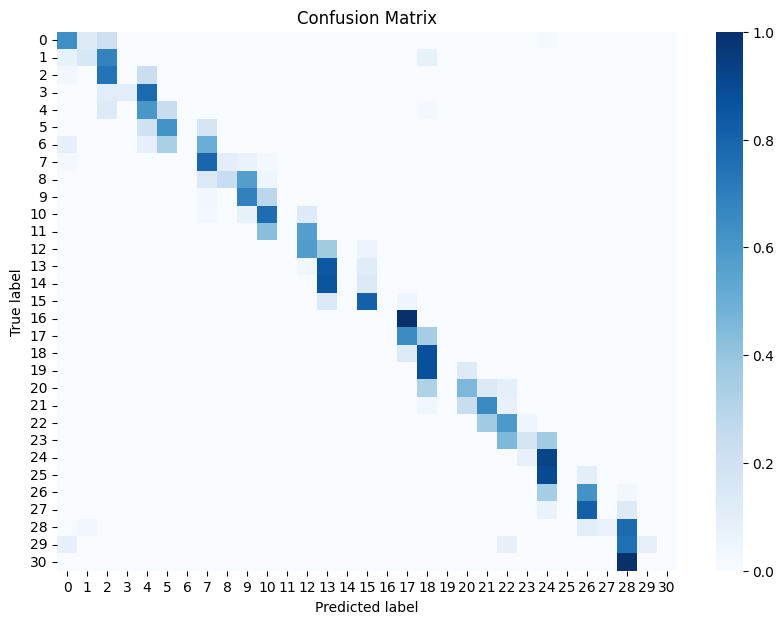

In [ ]:
modality = 'vision'
vision_ckpt = '/content/checkpoint/beam_pred_model_vision_v2'
model_vision = get_model(modality, num_classes=65)
model_vision = model_vision.to(device)

best_model_path = vision_ckpt  # This should be the path where the best model is saved
model_vision.load_state_dict(torch.load(best_model_path))
model_vision.to(device)  # Ensure model is on the correct device

model_vision.eval()

train_scenario_nums = [1, 2, 3]  # Scenarios 1, 2, and 3 will be used for training
test_scenario_nums = [1, 2, 3]      # Scenarios 4 and 5 will be used for testing

# Define the percentage of data to be used from each training scenario
percentages = [40, 40, 40]  # Use 40% of Scenario 1, 40% of Scenario 2, and 40% of Scenario 3

# Run the function
train_df_vision, val_df_vision, test_df_vision = combine_shuffle_datasets(train_scenario_nums, test_scenario_nums, modality, percentages)

val_batch_size = 1
num_workers = 2

test_dataset = CustomDataset(dataframe=test_df_vision, modality=modality, transform=test_transforms)

test_loader = DataLoader(test_dataset,
                        batch_size=val_batch_size,
                        shuffle=False,
                        num_workers=num_workers)




_, _, _, test_results_vision = validate(model_vision, test_loader, device, modality)

# Assuming `results` is returned from `validate`
labels = test_results_vision['labels']
top1_preds = test_results_vision['top1_pred']

# Calculate the confusion matrix
cm = confusion_matrix(labels, top1_preds)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 7))
sns.heatmap(cm_normalized, cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Transfer Learning Overview
**Transfer learning** is a powerful machine learning technique that leverages knowledge gained from one problem to solve related but distinct problems. It's particularly useful when you have limited data for a new task, but access to a related task with an abundance of data.

In practice, transfer learning typically involves taking a model trained on a large dataset and fine-tuning it on a smaller, specific dataset. This approach is prevalent in deep learning, especially in domains like image recognition and natural language processing, where pretrained models like ResNet for images or BERT for text are adapted to new tasks.

**Key Benefits:**

**Efficiency:** Speeds up the time to train a model as the need for training from scratch is eliminated.

**Performance:** Often achieves higher performance, especially in tasks where the data is scarce or not diverse enough.

**Steps in Transfer Learning:**

*   **Select a Pretrained Model:** Choose a model trained on a large dataset that is similar to your new task.
*   **Feature Extraction:** Use the pretrained model to transform new data into a better feature space.
*   **Fine-Tuning:** Optionally, continue training the model on the new data to adapt the model weights better to the specific task.

This methodology allows for the rapid deployment of robust models across various tasks, significantly cutting down on development time and computational resources.

In [ ]:
modality = 'vision'
vision_ckpt = '/content/checkpoint/beam_pred_model_vision_v2'
model_vision = get_model(modality, num_classes=65)
model_vision = model_vision.to(device)

best_model_path = vision_ckpt  # This should be the path where the best model is saved
model_vision.load_state_dict(torch.load(best_model_path))
model_vision.to(device)  # Ensure model is on the correct device

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


CustomImageModel(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, t

Validation: 100%|██████████| 187/187 [00:02<00:00, 84.47it/s]


Validation Accuracy - Top1: 0.3850267379679144, Top2: 0.6149732620320856, Top3: 0.7379679144385026


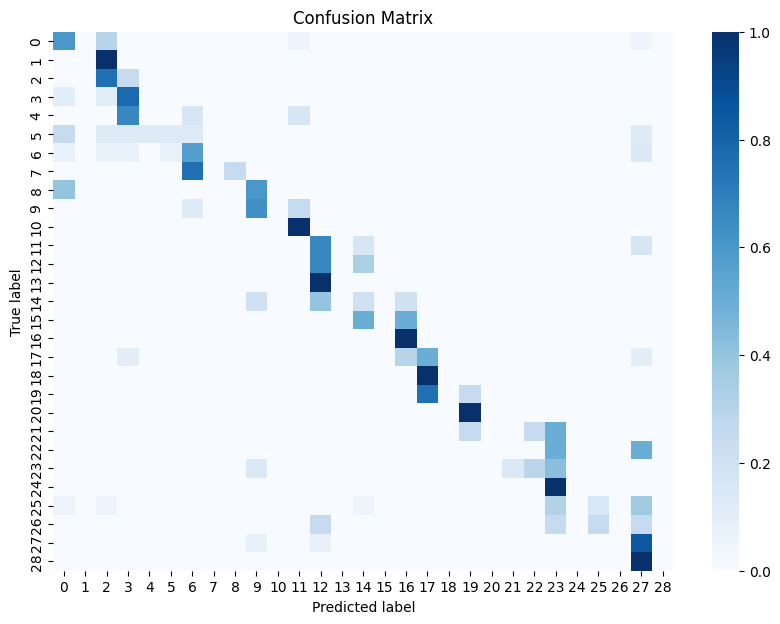

In [ ]:
modality = 'vision'

train_scenario_nums = [4]  # Scenarios 1, 2, and 3 will be used for training
test_scenario_nums = [4]      # Scenarios 4 and 5 will be used for testing

# Define the percentage of data to be used from each training scenario
percentages = [100]  # Use 20% of Scenario 4

# Run the function
train_df_s4, val_df_s4, test_df_s4 = combine_shuffle_datasets(train_scenario_nums, test_scenario_nums, modality, percentages)

val_batch_size = 1
num_workers = 2

test_dataset = CustomDataset(dataframe=test_df_s4, modality=modality, transform=test_transforms)

test_loader = DataLoader(test_dataset,
                        batch_size=val_batch_size,
                        shuffle=False,
                        num_workers=num_workers)




_, _, _, test_results_s4 = validate(model_vision, test_loader, device, modality)

# Assuming `results` is returned from `validate`
labels = test_results_s4['labels']
top1_preds = test_results_s4['top1_pred']

# Calculate the confusion matrix
cm = confusion_matrix(labels, top1_preds)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 7))
sns.heatmap(cm_normalized, cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

**Training with a pre-trained model**

Motivation: Site-Specific Training vs. General Training

In [ ]:
def main_training_loop_w_pre_trained_model(model, train_df, val_df, test_df, device, modality, ckpt_name):

    #model = get_model(modality, num_classes=65)
    #model = model.to(device)


    print(pwd)

    train_df.to_csv(f'{pwd}/train.csv', index=False)
    val_df.to_csv(f'{pwd}/val.csv', index=False)
    test_df.to_csv(f'{pwd}/test.csv', index=False)

    # Set the batch sizes and number of workers
    batch_size = 64
    val_batch_size = 1
    num_workers = 2  # Adjust based on the capabilities of your machine

    lr = 1e-4
    decay = 1e-4


    # Create dataset instances for each DataFrame
    train_dataset = CustomDataset(dataframe=train_df, modality=modality, transform=train_transforms)
    val_dataset = CustomDataset(dataframe=val_df, modality=modality, transform=test_transforms)
    test_dataset = CustomDataset(dataframe=test_df, modality=modality, transform=test_transforms)

    # Set up the DataLoader for each dataset
    train_loader = DataLoader(train_dataset,
                              batch_size=batch_size,
                              shuffle=True,  # Shuffle for training to randomize input
                              num_workers=num_workers)

    val_loader = DataLoader(val_dataset,
                            batch_size=val_batch_size,
                            shuffle=False,  # No need to shuffle validation and test data
                            num_workers=num_workers)

    test_loader = DataLoader(test_dataset,
                            batch_size=val_batch_size,
                            shuffle=False,
                            num_workers=num_workers)


    criterion = nn.CrossEntropyLoss()
    opt = optimizer.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
    if modality == 'position':
        scheduler = optimizer.lr_scheduler.MultiStepLR(opt, milestones=[20, 40], gamma=0.1)
        num_epochs = 50
    else:
        scheduler = optimizer.lr_scheduler.MultiStepLR(opt, milestones=[4, 8], gamma=0.1)
        num_epochs = 10

    best_accuracy = 0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}')
        train(model, train_loader, criterion, opt, device, modality)
        accuracy, _, _, results = validate(model, val_loader, device, modality)
        log_and_save_results(results, save_directory, epoch)

        print("current acc", accuracy)
        print("best acc", best_accuracy)
        if accuracy > best_accuracy:
            print("Saving the best model")
            #net_name = checkpoint_directory  + '/' +  f'beam_pred_model_{modality}_transfer_learning'
            net_name = checkpoint_directory  + '/' +  ckpt_name
            torch.save(model.state_dict(), net_name)
            best_accuracy =  accuracy
        print("updated best acc", best_accuracy)

        scheduler.step()



    # Load the best checkpoint
    # Assuming the best model's name is preserved in `net_name`, load the best model
    best_model_path = net_name  # This should be the path where the best model is saved
    model.load_state_dict(torch.load(best_model_path))
    model.to(device)  # Ensure model is on the correct device

    print("Model accuracy on the test set")

    # Optionally, evaluate the model to confirm it's loaded correctly and check performance
    model.eval()
    test_accuracy, _, _, test_results = validate(model, val_loader, device, modality)
    #print(f'Loaded Model Accuracy: {accuracy}')
    return model, test_results

In [ ]:
modality = 'vision'
ckpt_name = f'beam_pred_model_{modality}_transfer_learning'
_, results_s4 = main_training_loop_w_pre_trained_model(model_vision, train_df_s4, val_df_s4, test_df_s4, device, modality, ckpt_name)

# Assuming `results` is returned from `validate`
labels = results_s4['labels']
top1_preds = results_s4['top1_pred']

# Calculate the confusion matrix
cm = confusion_matrix(labels, top1_preds)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 7))
sns.heatmap(cm_normalized, cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

/content/ML_code/saved_folder/05-22-2024_12_12
Epoch 1


Training:   0%|          | 0/18 [00:02<?, ?it/s]


KeyboardInterrupt: 

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Validation: 100%|██████████| 187/187 [00:02<00:00, 78.63it/s]


Validation Accuracy - Top1: 0.6577540106951871, Top2: 0.8556149732620321, Top3: 0.9679144385026738


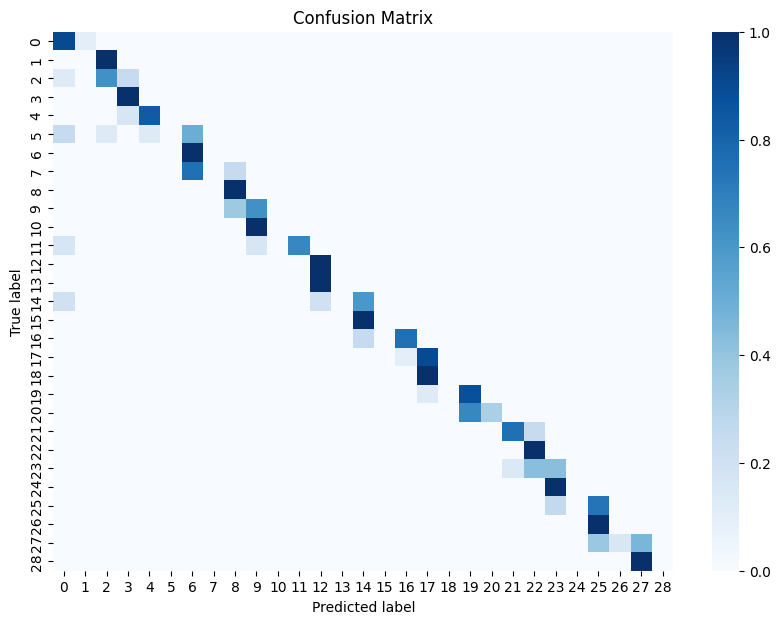

In [ ]:
modality = 'vision'
tf_vision_ckpt = '/content/checkpoint/beam_pred_model_vision_transfer_learning'
model_vision_tf = get_model(modality, num_classes=65)
model_vision_tf = model_vision_tf.to(device)

best_model_path = tf_vision_ckpt  # This should be the path where the best model is saved
model_vision_tf.load_state_dict(torch.load(best_model_path))
model_vision_tf.to(device)  # Ensure model is on the correct device

model_vision_tf.eval()


val_batch_size = 1
num_workers = 2

test_dataset = CustomDataset(dataframe=test_df_s4, modality=modality, transform=test_transforms)

test_loader = DataLoader(test_dataset,
                        batch_size=val_batch_size,
                        shuffle=False,
                        num_workers=num_workers)




_, _, _, test_results_s4 = validate(model_vision_tf, test_loader, device, modality)

# Assuming `results` is returned from `validate`
labels = test_results_s4['labels']
top1_preds = test_results_s4['top1_pred']

# Calculate the confusion matrix
cm = confusion_matrix(labels, top1_preds)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 7))
sns.heatmap(cm_normalized, cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

**How much data do we need?**

In [ ]:
train_scenario_nums = [4]  # Scenarios 1, 2, and 3 will be used for training
test_scenario_nums = [4]      # Scenarios 4 and 5 will be used for testing

# Define the percentage of data to be used from each training scenario
percentages = [40]  # Use 40% of Scenario 4

# Run the function
train_df_s4, val_df_s4, test_df_s4 = combine_shuffle_datasets(train_scenario_nums, test_scenario_nums, modality, percentages)

modality = 'vision'
ckpt_name = f'beam_pred_model_{modality}_transfer_learning_partial_dataset'
_, results_s4 = main_training_loop_w_pre_trained_model(model_vision, train_df_s4, val_df_s4, test_df_s4, device, modality, ckpt_name)

# Assuming `results` is returned from `validate`
labels = results_s4['labels']
top1_preds = results_s4['top1_pred']

# Calculate the confusion matrix
cm = confusion_matrix(labels, top1_preds)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 7))
sns.heatmap(cm_normalized, cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Validation: 100%|██████████| 187/187 [00:03<00:00, 48.25it/s]


Validation Accuracy - Top1: 0.6042780748663101, Top2: 0.8128342245989305, Top3: 0.93048128342246


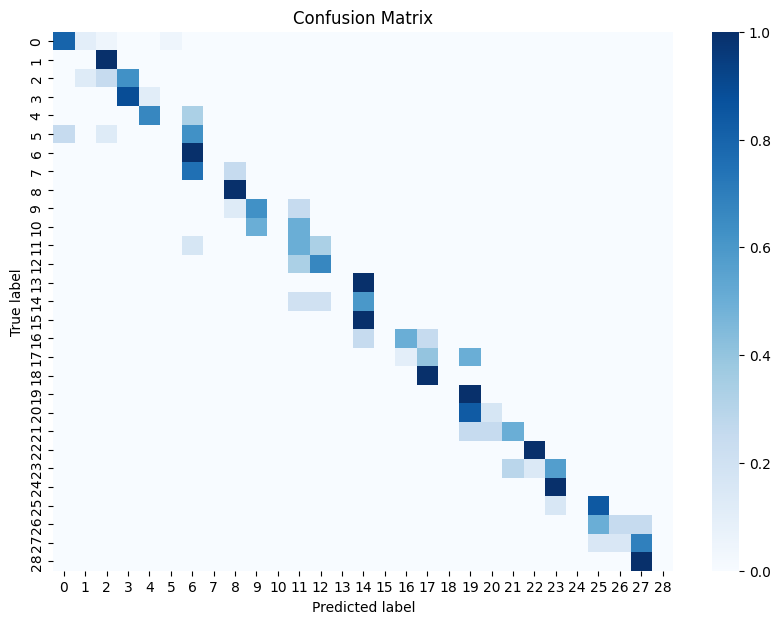

In [ ]:
modality = 'vision'
tf_pd_vision_ckpt = '/content/checkpoint/beam_pred_model_vision_transfer_learning_partial_dataset'
model_vision_tf_pd = get_model(modality, num_classes=65)
model_vision_tf_pd = model_vision_tf_pd.to(device)

best_model_path = tf_pd_vision_ckpt  # This should be the path where the best model is saved
model_vision_tf_pd.load_state_dict(torch.load(best_model_path))
model_vision_tf_pd.to(device)  # Ensure model is on the correct device

model_vision_tf_pd.eval()


val_batch_size = 1
num_workers = 2

test_dataset = CustomDataset(dataframe=test_df_s4, modality=modality, transform=test_transforms)

test_loader = DataLoader(test_dataset,
                        batch_size=val_batch_size,
                        shuffle=False,
                        num_workers=num_workers)




_, _, _, test_results_s4 = validate(model_vision_tf_pd, test_loader, device, modality)

# Assuming `results` is returned from `validate`
labels = test_results_s4['labels']
top1_preds = test_results_s4['top1_pred']

# Calculate the confusion matrix
cm = confusion_matrix(labels, top1_preds)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 7))
sns.heatmap(cm_normalized, cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()